In [1]:
import sys  
sys.path.insert(1, '.\..\..\SOURCES\.')

import random

random.seed(10)

from DATA import MG17
from Reservoir import Reservoir

In [2]:
data = MG17(True, [90,0,10])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

In [3]:
from IPReservoir import IPReservoir
from ESN import EchoStateNetwork
from IPMask import IPMask
from Reservoir import Reservoir
from Metrics import *
from Evaluator import * 

In [4]:
import seaborn as sns

In [5]:
N = 100
init_point = Reservoir(N=N, desired_rho=0.7, bias = False,)
names = ["Gaussian", "Bimodal", "Soft Trimodal", "Edgy Trimodal"]

masks = [
    IPMask.gaussian(N, std=0.2),
    IPMask.bimodal(N, mu=0.85, std=0.15),
    IPMask.trimodal(N, linear_rate=0.4, std_bim=0.18), 
    IPMask.trimodal(N, linear_rate=0.2, mu=0.85, std_bim=0.18)
    ]

models = [IPReservoir.clone(init_point) for _ in range(len(names))]

#for mask,model in zip(masks, models): 
#    model.set_IP_mask(mask)

In [6]:
epochs = 15
eta = 0.0000025

In [7]:
results = []

for _ in range(10):
    init_point = Reservoir(N=N, desired_rho=0.7, bias = False)
    models = [IPReservoir.clone(init_point) for _ in range(len(names))]
    for mask,model in zip(masks, models): 
        model.set_IP_mask(mask, False)
    for idx, model in enumerate(models): 
        row = [names[idx], idx, 0, model.evalaute_loss(X_TS), model.rho(), model.a.norm(), model.b.norm()]
        results.append(row)
    for e in range(epochs): 
        for idx, model in enumerate(models): 
            model.IP_online(X_TR, eta, 1, eval_kl=X_TS)
            row = [names[idx], idx, e+1, model.loss, model.rho(), model.a.norm(), model.b.norm()]
            results.append(row)

In [8]:
model.mask.to_permute

False

In [9]:
columns = ["Name", "Model Idx", "Epoch", "KL", "Rho", "A-Norm", "B-Norm"]

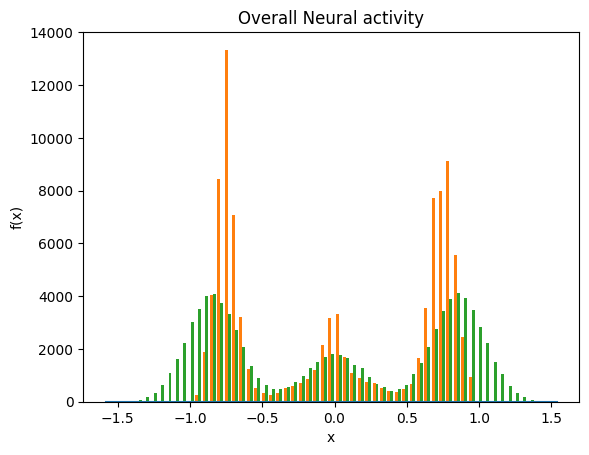

In [10]:
model.plot_neural_activity(X_TS)

In [11]:
df = pd.DataFrame(results, columns=columns)

In [12]:
# Function to convert tensors to float
def convert_to_float(tensor):
    return tensor.item() if isinstance(tensor, torch.Tensor) and tensor.shape == torch.Size([]) else tensor

# Apply the conversion function to the entire DataFrame
df = df.applymap(convert_to_float)

In [13]:
df.to_csv("Unpermuted_KL.csv")

In [39]:
def plot_evolution(attribute_name, palette_name='husl'):
    # Set Seaborn style and color palette
    sns.set(style='whitegrid')
    sns.set_palette(palette_name)

    result_df = df.groupby(['Epoch', 'Model Idx']).agg({attribute_name: ['mean', 'std']}).reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Store colors for error bars and markers
    colors = sns.color_palette(palette_name, n_colors=len(result_df['Model Idx'].unique()))

    for model_idx, color in zip(result_df['Model Idx'].unique(), colors):
        group = result_df[result_df['Model Idx'] == model_idx]
        label = names[model_idx]  # Assuming model_idx starts from 1

        # Plot line
        ax.plot(group['Epoch'], group[(attribute_name, 'mean')], label=label, color=color, marker='o')

        # Add error bars at epoch 0
        if 0 in group['Epoch'].values:
            error_bar_values = group[group['Epoch'] == 0][(attribute_name, 'std')].values[0]
            ax.errorbar(0, group[(attribute_name, 'mean')].values[0],
                        yerr=error_bar_values, color=color, capsize=5)

        # Add fill between for the entire evolution
        ax.fill_between(group['Epoch'],
                        group[(attribute_name, 'mean')] - group[(attribute_name, 'std')],
                        group[(attribute_name, 'mean')] + group[(attribute_name, 'std')],
                        color=color, alpha=0.2)

    ax.set_xlabel('Epoch')
    ax.set_ylabel(attribute_name)
    #ax.legend(loc='upper right', title='')
    #ax.set_title(f'{attribute_name} Evolution Over Epochs (No initial permutation)')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.show()


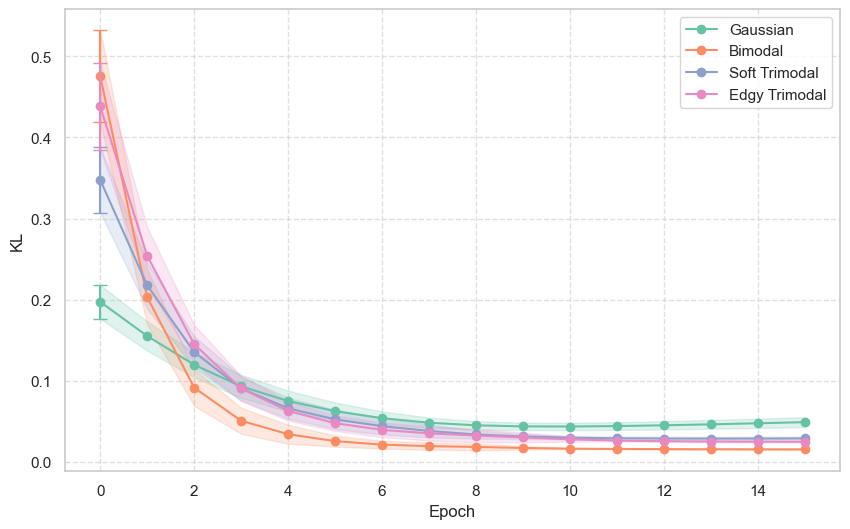

In [37]:
# Example usage:
plot_evolution('KL', palette_name='Set2')

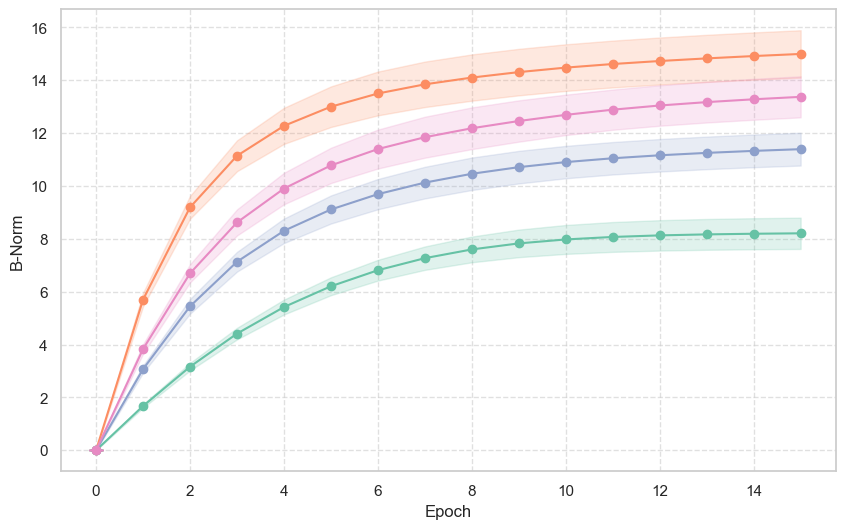

In [40]:
# Example usage:
plot_evolution('B-Norm', palette_name='Set2')

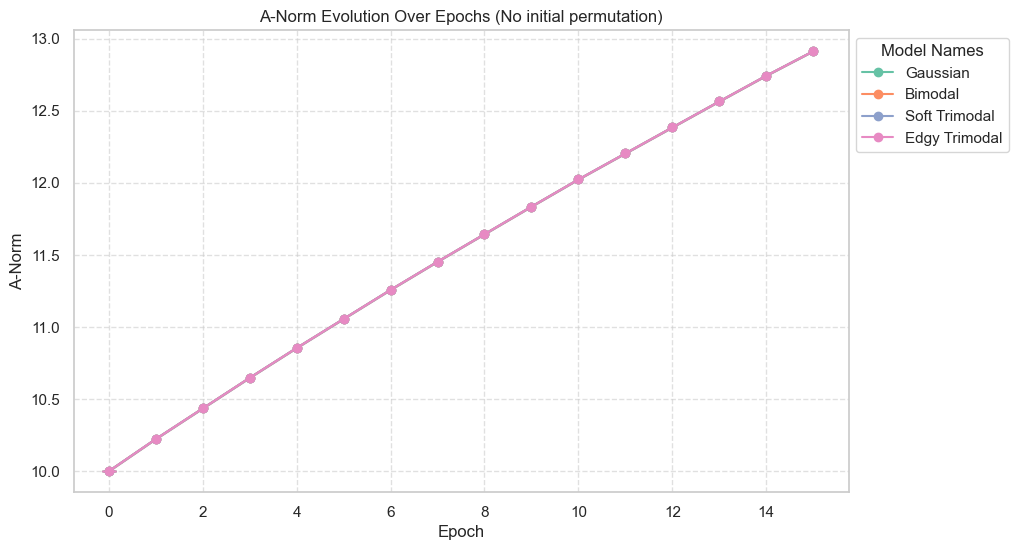

In [23]:
# Example usage:
plot_evolution('A-Norm', palette_name='Set2')

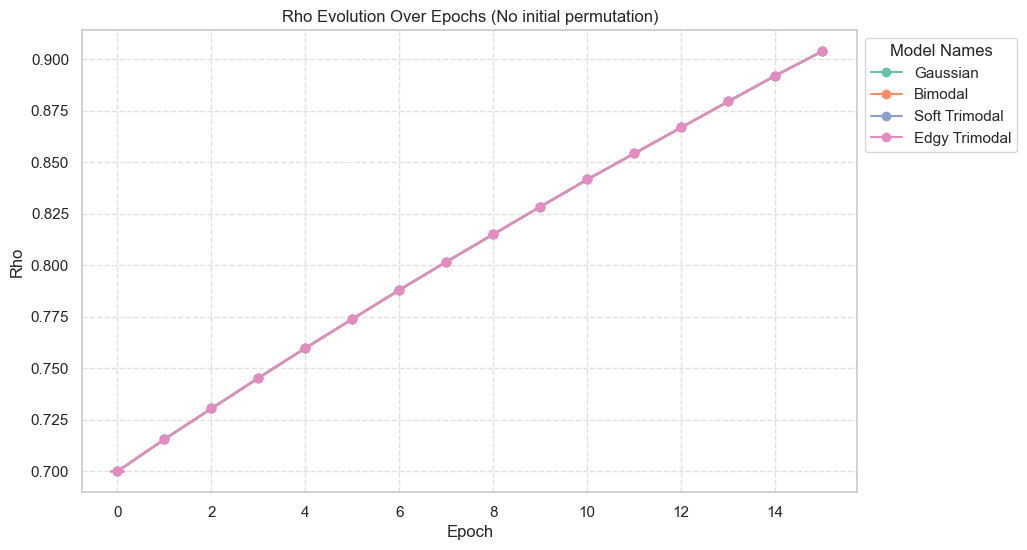

In [24]:
# Example usage:
plot_evolution('Rho', palette_name='Set2')